# 4-D phase space reconstruction
Here we test 4-d phase space reconstruction using a basic quadrupole scan and a screen. The test uses a dummy phase space distribution in the 4d transverse phase space.

### Python package imports

In [1]:
import numpy as np
import torch
import lightning as L
from cheetah import ParticleBeam, Screen
from gpsr.modeling import GPSR, GPSRQuadScanLattice
from gpsr.train import LitGPSR
from gpsr.beams import NNParticleBeamGenerator
from gpsr.datasets import QuadScanDataset, split_dataset

### Import test beam distribution and visualize 6d phase space

In [2]:
# create synthetic ground truth beam from base and transform yaml files
p0c = 43.36e6  # reference momentum in eV/c

gt_beam = torch.load(
    "../example_data/example_distributions/complex_beam.pt", weights_only=False
)
gt_beam = ParticleBeam(gt_beam.particles, gt_beam.energy)

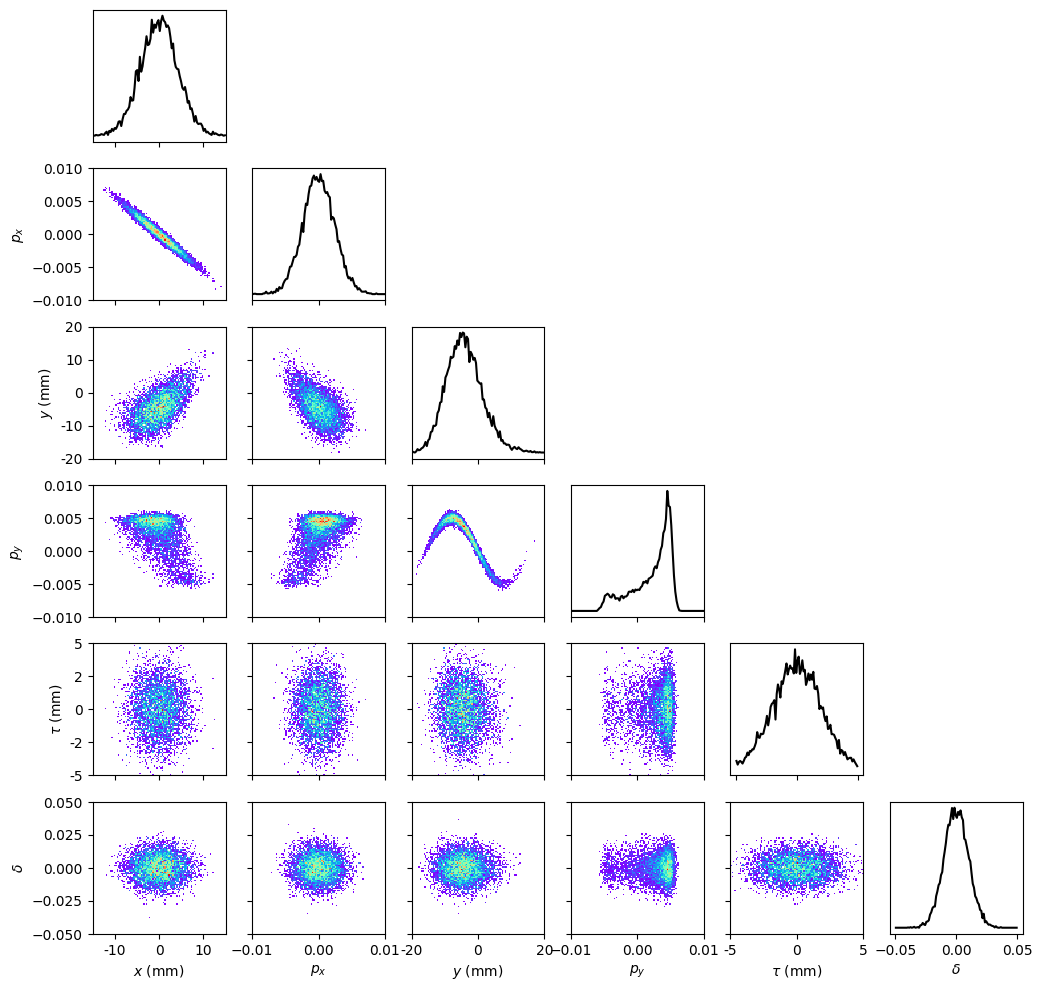

In [3]:
# plot synthetic ground truth beam projections

lims = [
    [-15e-3, 15e-3],
    [-10e-3, 10e-3],
    [-20e-3, 20e-3],
    [-10e-3, 10e-3],
    [-5e-3, 5e-3],
    [-5e-2, 5e-2],
]
gt_beam.plot_distribution(bin_ranges=lims);

### Create the screen diagnostic
Here we use the differentiable Cheetah `Screen`. This screen uses kernel desity estimation to approximate the histogram in order to make it differentiable and vectorized.

In [4]:
# create diagnostic screen:
n_pixels = 100
pixel_size = torch.tensor(1e-3)
screen = Screen(
    resolution=(n_pixels, n_pixels),
    pixel_size=torch.tensor((pixel_size, pixel_size)),
    method="kde",
    kde_bandwidth=pixel_size,
    is_active=True,
)

### Create synthetic data
We track the dummy beam distribution through a dummy lattice (containing a quadrupole and drift) with different quadrupole strengths to get the training images for GPSR.

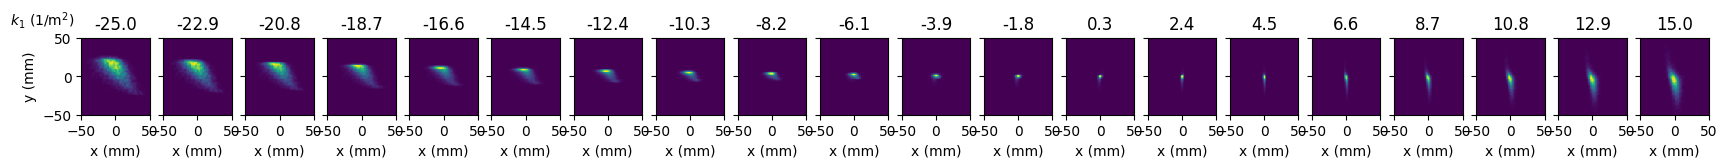

In [5]:
# create synthetic data
# get model
gpsr_lattice = GPSRQuadScanLattice(l_quad=0.1, l_drift=1.0, screen=screen)

# quadrupole strengths for scan (reshape as: n_quad_strengths x n_images_per_quad_strength x 1)
n_ks = 20
ks = torch.linspace(-25, 15, n_ks).unsqueeze(-1)
gpsr_lattice.set_lattice_parameters(ks)

# propagate beam and get images
images = gpsr_lattice.track_and_observe(gt_beam)[0]

# create dataset
dataset = QuadScanDataset(ks, images, screen=screen)

# split dataset into training and test sets
train_k_ids = np.arange(0, len(dataset.parameters), 2)
train_dset, test_dset = split_dataset(dataset, train_k_ids)

dataset.plot_data();

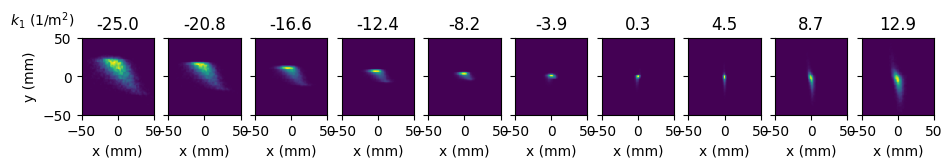

In [6]:
train_dset.plot_data();

In [7]:
torch.save(dataset, "../example_data/example_datasets/reconstruction_4D.dset")

### Define the GPSR model for training
The GPSR model contains the ML-based parameterization of the initial beam distribution `NNParticleBeamGenerator` with 10k particles and the differentiable simulation of the diagnostic lattice (same one used above to generate the training data).

In [8]:
gpsr_model = GPSR(NNParticleBeamGenerator(10000, p0c), gpsr_lattice)
train_loader = torch.utils.data.DataLoader(train_dset, batch_size=20)

litgpsr = LitGPSR(gpsr_model)
logger = L.pytorch.loggers.TensorBoardLogger(
    ".",
)

### Perform the reconstruction
This cell performs the reconstruction by varying the parameters of `NNParticleBeamGenerator` to minimize the difference between predicted measurements and the training data. This step will take some time on a CPU but can be greatly accelerated (1-2 orders of magnitude) if using a GPU to do the computation. If you are limited to a CPU I would recommend reducing the number of `max_epochs` to be between 500-1000 to reduce computation time.

In [9]:
trainer = L.Trainer(limit_train_batches=100, max_epochs=2000, logger=logger)
trainer.fit(model=litgpsr, train_dataloaders=train_loader)

Using default `ModelCheckpoint`. Consider installing `litmodels` package to enable `LitModelCheckpoint` for automatic upload to the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name       | Type | Params | Mode 
--------------------------------------------
0 | gpsr_model | GPSR | 1.1 K  | train
--------------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)
18        Modules in train mode
0         Modules in eval mode
/Users/pablo/miniforge3/envs/csr-psr/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.
/Users/pablo/miniforge3/envs/csr-psr/

Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 24.31it/s, v_num=2]

`Trainer.fit` stopped: `max_epochs=2000` reached.


Epoch 1999: 100%|██████████| 1/1 [00:00<00:00, 19.18it/s, v_num=2]


### Get the reconstructed beam distribution

In [10]:
reconstructed_beam = litgpsr.gpsr_model.beam_generator()

### Evaluate model on samples to compare predictions
Here we use the trained GPSR model to make predictions that should agree with the training data. The plot below shows the training data as the colormap and uses contour lines to show the predicted measurements at the 10th, 50th, 95th percentiles.

In [11]:
test_pred = gpsr_model(train_dset.parameters)[0].detach()
test_pred_dset = QuadScanDataset(train_dset.parameters, test_pred, screen=screen)
test_pred_dset.observations[0].shape

torch.Size([10, 100, 100])

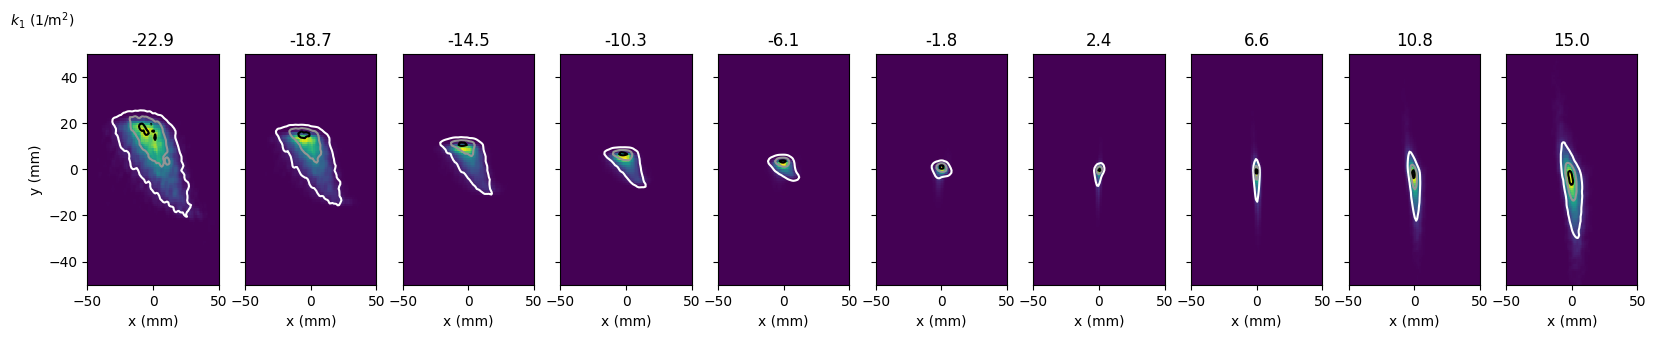

In [12]:
fig, ax = test_dset.plot_data(overlay_data=test_pred_dset)
fig.set_size_inches(20, 3)

### Compare reconstructed distribution to ground truth distribution
Here we compare 2d projections of each distribution to see agreement. Note that because we are only using a quadrupole to rotate the phase space, projections associated with the longitudinal phase space coordinates will be inaccurate and should be ignored. See the 6d reconstruction examples for a case where we can reconstruct those distributions as well.

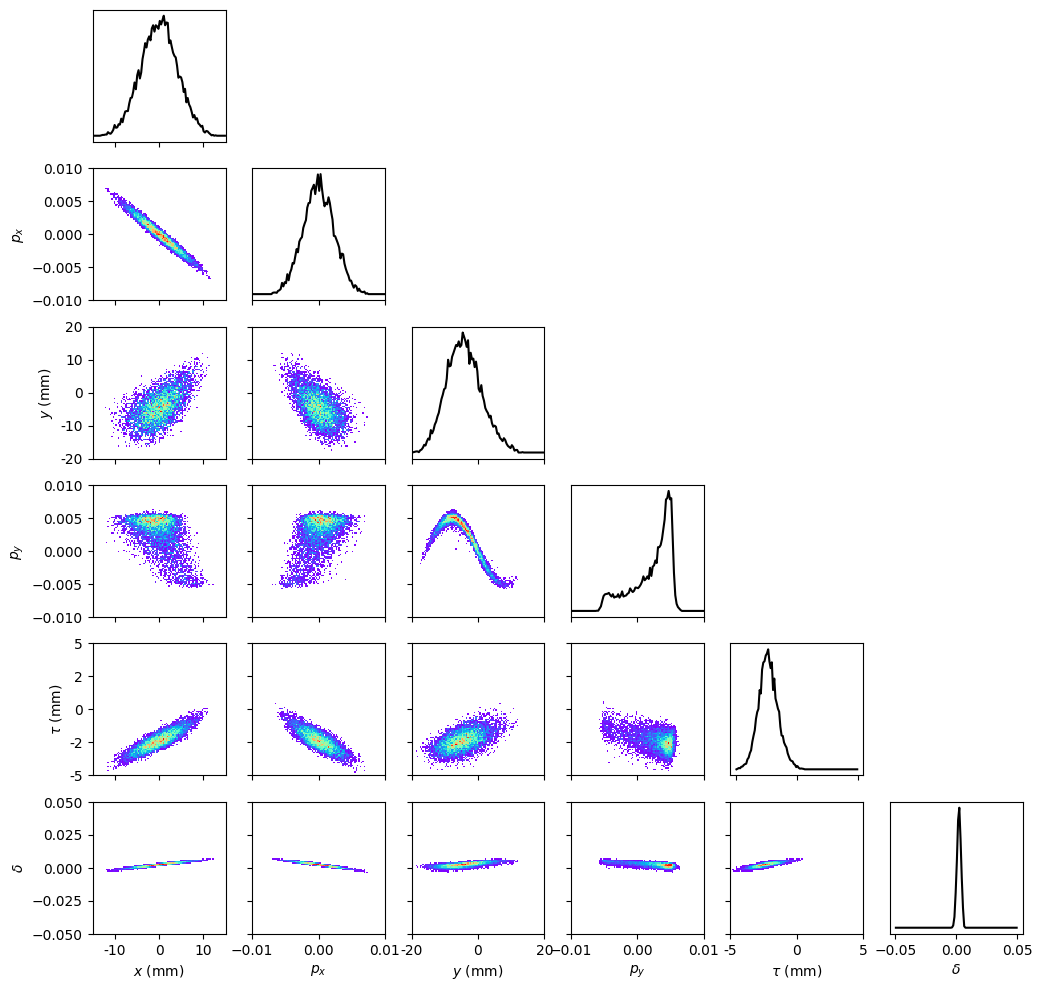

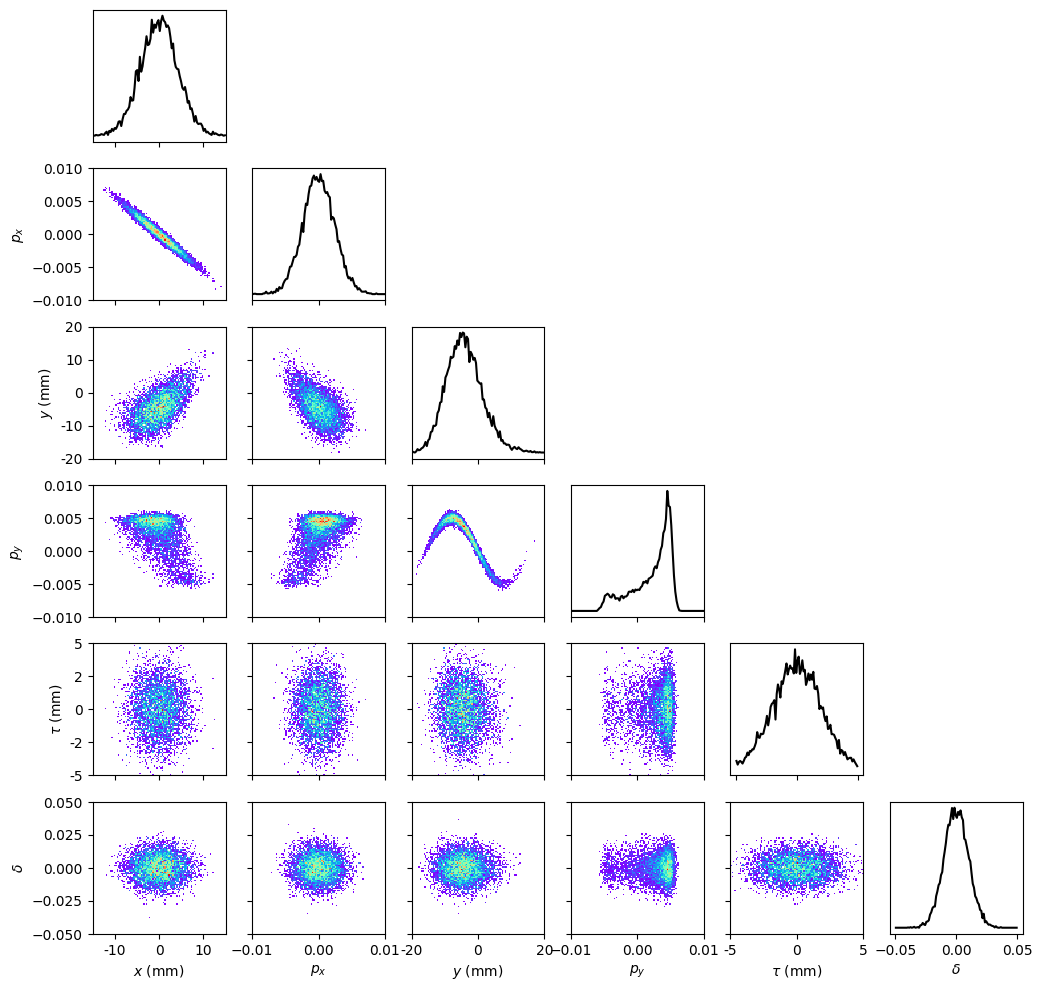

In [13]:
reconstructed_beam.plot_distribution(bin_ranges=lims)
gt_beam.plot_distribution(bin_ranges=lims);